<a href="https://www.kaggle.com/code/lukalafaye/gan-mnist-dslab2?scriptVersionId=206814732" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Recall / Precision stuff

In [1]:
#!/usr/bin/env python3
import os
from functools import partial
from collections import namedtuple
from glob import glob
import numpy as np
from PIL import Image
from argparse import ArgumentParser, ArgumentDefaultsHelpFormatter
from tqdm import tqdm
from tqdm import trange

import torch
import torchvision.models as models
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets
from torchvision.utils import save_image

Manifold = namedtuple("Manifold", ["features", "radii"])
PrecisionAndRecall = namedtuple("PrecisionAndRecall", ["precision", "recall"])


def convert_mnist_to_images(output_dir, num_images=100):
    os.makedirs(output_dir, exist_ok=True)
    transform = transforms.Compose([transforms.ToTensor()])
    mnist_data = datasets.MNIST(
        root="data/MNIST", train=True, transform=transform, download=True
    )

    for i in range(num_images):
        img, label = mnist_data[i]
        save_image(img, os.path.join(output_dir, f"real_{i}.png"))
    print(f"Converted {num_images} MNIST images to PNG format in '{output_dir}'.")


class IPR:
    def __init__(self, batch_size=50, k=3, num_samples=10000, model=None):
        self.manifold_ref = None
        self.batch_size = batch_size
        self.k = k
        self.num_samples = num_samples
        if model is None:
            print(
                "loading vgg16 for improved precision and recall...", end="", flush=True
            )
            self.vgg16 = models.vgg16(pretrained=True).cuda().eval()
            print("done")
        else:
            self.vgg16 = model

    def __call__(self, subject):
        return self.precision_and_recall(subject)

    def precision_and_recall(self, subject):
        """
        Compute precision and recall for given subject
        reference should be precomputed by IPR.compute_manifold_ref()
        args:
            subject: path or images
                path: a directory containing images or precalculated .npz file
                images: torch.Tensor of N x C x H x W
        returns:
            PrecisionAndRecall
        """
        assert self.manifold_ref is not None, "call IPR.compute_manifold_ref() first"

        manifold_subject = self.compute_manifold(subject)
        precision = compute_metric(
            self.manifold_ref, manifold_subject.features, "computing precision..."
        )
        recall = compute_metric(
            manifold_subject, self.manifold_ref.features, "computing recall..."
        )
        return PrecisionAndRecall(precision, recall)

    def compute_manifold_ref(self, path):
        self.manifold_ref = self.compute_manifold(path)

    def realism(self, image):
        """
        args:
            image: torch.Tensor of 1 x C x H x W
        """
        feat = self.extract_features(image)
        return realism(self.manifold_ref, feat)

    def compute_manifold(self, input):
        """
        Compute manifold of given input
        args:
            input: path or images, same as above
        returns:
            Manifold(features, radii)
        """
        # features
        if isinstance(input, str):
            if input.endswith(".npz"):  # input is precalculated file
                print("loading", input)
                f = np.load(input)
                feats = f["feature"]
                radii = f["radii"]
                f.close()
                return Manifold(feats, radii)
            else:  # input is dir
                feats = self.extract_features_from_files(input)
        elif isinstance(input, torch.Tensor):
            feats = self.extract_features(input)
        elif isinstance(input, np.ndarray):
            input = torch.Tensor(input)
            feats = self.extract_features(input)
        elif isinstance(input, list):
            if isinstance(input[0], torch.Tensor):
                input = torch.cat(input, dim=0)
                feats = self.extract_features(input)
            elif isinstance(input[0], np.ndarray):
                input = np.concatenate(input, axis=0)
                input = torch.Tensor(input)
                feats = self.extract_features(input)
            elif isinstance(input[0], str):  # input is list of fnames
                feats = self.extract_features_from_files(input)
            else:
                raise TypeError
        else:
            print(type(input))
            raise TypeError

        # radii
        distances = compute_pairwise_distances(feats)
        radii = distances2radii(distances, k=self.k)
        return Manifold(feats, radii)

    def extract_features(self, images):
        """
        Extract features of vgg16-fc2 for all images
        params:
            images: torch.Tensors of size N x C x H x W
        returns:
            A numpy array of dimension (num images, dims)
        """
        desc = "extracting features of %d images" % images.size(0)
        num_batches = int(np.ceil(images.size(0) / self.batch_size))
        _, _, height, width = images.shape
        if height != 224 or width != 224:
            print("IPR: resizing %s to (224, 224)" % str((height, width)))
            resize = partial(F.interpolate, size=(224, 224))
        else:

            def resize(x):
                return x

        features = []
        for bi in trange(num_batches, desc=desc):
            start = bi * self.batch_size
            end = start + self.batch_size
            batch = images[start:end]
            batch = resize(batch)
            before_fc = self.vgg16.features(batch.cuda())
            before_fc = before_fc.view(-1, 7 * 7 * 512)
            feature = self.vgg16.classifier[:4](before_fc)
            features.append(feature.cpu().data.numpy())

        return np.concatenate(features, axis=0)

    def extract_features_from_files(self, path_or_fnames):
        """
        Extract features of vgg16-fc2 for all images in path
        params:
            path_or_fnames: dir containing images or list of fnames(str)
        returns:
            A numpy array of dimension (num images, dims)
        """

        dataloader = get_custom_loader(
            path_or_fnames, batch_size=self.batch_size, num_samples=self.num_samples
        )
        num_found_images = len(dataloader.dataset)
        desc = "extracting features of %d images" % num_found_images
        if num_found_images < self.num_samples:
            print(
                "WARNING: num_found_images(%d) < num_samples(%d)"
                % (num_found_images, self.num_samples)
            )

        features = []
        for batch in tqdm(dataloader, desc=desc):
            before_fc = self.vgg16.features(batch.cuda())
            before_fc = before_fc.view(-1, 7 * 7 * 512)
            feature = self.vgg16.classifier[:4](before_fc)
            features.append(feature.cpu().data.numpy())

        return np.concatenate(features, axis=0)

    def save_ref(self, fname):
        print("saving manifold to", fname, "...")
        np.savez_compressed(
            fname, feature=self.manifold_ref.features, radii=self.manifold_ref.radii
        )


def compute_pairwise_distances(X, Y=None):
    """
    args:
        X: np.array of shape N x dim
        Y: np.array of shape N x dim
    returns:
        N x N symmetric np.array
    """
    num_X = X.shape[0]
    if Y is None:
        num_Y = num_X
    else:
        num_Y = Y.shape[0]
    X = X.astype(np.float64)  # to prevent underflow
    X_norm_square = np.sum(X**2, axis=1, keepdims=True)
    if Y is None:
        Y_norm_square = X_norm_square
    else:
        Y_norm_square = np.sum(Y**2, axis=1, keepdims=True)
    X_square = np.repeat(X_norm_square, num_Y, axis=1)
    Y_square = np.repeat(Y_norm_square.T, num_X, axis=0)
    if Y is None:
        Y = X
    XY = np.dot(X, Y.T)
    diff_square = X_square - 2 * XY + Y_square

    # check negative distance
    min_diff_square = diff_square.min()
    if min_diff_square < 0:
        idx = diff_square < 0
        diff_square[idx] = 0
        print(
            "WARNING: %d negative diff_squares found and set to zero, min_diff_square="
            % idx.sum(),
            min_diff_square,
        )

    distances = np.sqrt(diff_square)
    return distances


def distances2radii(distances, k=3):
    num_features = distances.shape[0]
    radii = np.zeros(num_features)
    for i in range(num_features):
        radii[i] = get_kth_value(distances[i], k=k)
    return radii


def get_kth_value(np_array, k):
    kprime = k + 1  # kth NN should be (k+1)th because closest one is itself
    idx = np.argpartition(np_array, kprime)
    k_smallests = np_array[idx[:kprime]]
    kth_value = k_smallests.max()
    return kth_value


def compute_metric(manifold_ref, feats_subject, desc=""):
    num_subjects = feats_subject.shape[0]
    count = 0
    dist = compute_pairwise_distances(manifold_ref.features, feats_subject)
    for i in trange(num_subjects, desc=desc):
        count += (dist[:, i] < manifold_ref.radii).any()
    return count / num_subjects


def is_in_ball(center, radius, subject):
    return distance(center, subject) < radius


def distance(feat1, feat2):
    return np.linalg.norm(feat1 - feat2)


def realism(manifold_real, feat_subject):
    feats_real = manifold_real.features
    radii_real = manifold_real.radii
    diff = feats_real - feat_subject
    dists = np.linalg.norm(diff, axis=1)
    eps = 1e-6
    ratios = radii_real / (dists + eps)
    max_realism = float(ratios.max())
    return max_realism


class ImageFolder(Dataset):
    def __init__(self, root, transform=None):
        # self.fnames = list(map(lambda x: os.path.join(root, x), os.listdir(root)))
        self.fnames = glob(os.path.join(root, "**", "*.jpg"), recursive=True) + glob(
            os.path.join(root, "**", "*.png"), recursive=True
        )

        self.transform = transform

    def __getitem__(self, index):
        image_path = self.fnames[index]
        image = Image.open(image_path).convert("RGB")
        if self.transform is not None:
            image = self.transform(image)
        return image

    def __len__(self):
        return len(self.fnames)


class FileNames(Dataset):
    def __init__(self, fnames, transform=None):
        self.fnames = fnames
        self.transform = transform

    def __getitem__(self, index):
        image_path = self.fnames[index]
        image = Image.open(image_path).convert("RGB")
        if self.transform is not None:
            image = self.transform(image)
        return image

    def __len__(self):
        return len(self.fnames)


def get_custom_loader(
    image_dir_or_fnames, image_size=224, batch_size=50, num_workers=4, num_samples=-1
):
    transform = []
    transform.append(transforms.Resize([image_size, image_size]))
    transform.append(transforms.ToTensor())
    transform.append(
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    )
    transform = transforms.Compose(transform)

    if isinstance(image_dir_or_fnames, list):
        dataset = FileNames(image_dir_or_fnames, transform)
    elif isinstance(image_dir_or_fnames, str):
        dataset = ImageFolder(image_dir_or_fnames, transform=transform)
    else:
        raise TypeError

    if num_samples > 0:
        dataset.fnames = dataset.fnames[:num_samples]
    data_loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
    )
    return data_loader


def toy():
    offset = 2
    feats_real = np.random.rand(10).reshape(-1, 1)
    feats_fake = np.random.rand(10).reshape(-1, 1) + offset
    feats_real[0] = offset
    feats_fake[0] = 1
    print("real:", feats_real)
    print("fake:", feats_fake)

    print("computing pairwise distances...")
    distances_real = compute_pairwise_distances(feats_real)
    print("distances to radii...")
    radii_real = distances2radii(distances_real)
    manifold_real = Manifold(feats_real, radii_real)

    print("computing pairwise distances...")
    distances_fake = compute_pairwise_distances(feats_fake)
    print("distances to radii...")
    radii_fake = distances2radii(distances_fake)
    manifold_fake = Manifold(feats_fake, radii_fake)

    precision = compute_metric(manifold_real, feats_fake)
    recall = compute_metric(manifold_fake, feats_real)
    print("precision:", precision)
    print("recall:", recall)

# SAN

In [2]:
!pip3 install torch torchview tqdm matplotlib pytorch-fid

# Generator

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np 
from torch.nn.utils import spectral_norm

class Generator(nn.Module):
    def __init__(self, g_output_dim=784, dim_latent=100):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(100, 256)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features*2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features*2)
        self.fc4 = nn.Linear(self.fc3.out_features, g_output_dim)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        return torch.tanh(self.fc4(x))

# Discriminator

In [23]:
class BaseDiscriminator(nn.Module):
    def __init__(self, d_input_dim=784):
        super(BaseDiscriminator, self).__init__()
        self.h_function = nn.Sequential(
            #nn.Linear(d_input_dim, 512),
            spectral_norm(nn.Linear(d_input_dim, 1024)),
            nn.LeakyReLU(0.2),
            #nn.Linear(1024, 512),
            #nn.LeakyReLU(0.2),
            #nn.Linear(512, 256),
            spectral_norm(nn.Linear(1024, 512)),
            nn.LeakyReLU(0.2),
            #nn.Linear(256, 1)
            spectral_norm(nn.Linear(512, 256)),
            nn.LeakyReLU(0.2),
        )

        self.fc_w = nn.Parameter(torch.randn(1, 256))

    def forward(self, x, flg_train: bool):        
        h_feature = self.h_function(x)
        weights = self.fc_w
        out = (h_feature * weights).sum(dim=1)
        return out

class SanDiscriminator(BaseDiscriminator):
    def __init__(self, d_input_dim=784):
        super(SanDiscriminator, self).__init__(d_input_dim)

    def forward(self, x, flg_train: bool):
        h_feature = self.h_function(x)        
        weights = self.fc_w
        direction = F.normalize(weights, dim=1)  # Normalize the last layer
        scale = torch.norm(weights, dim=1).unsqueeze(1)
        h_feature = h_feature * scale  # Keep the scale
        if flg_train:  # For discriminator training
            out_fun = (h_feature * direction.detach()).sum(dim=1)
            out_dir = (h_feature.detach() * direction).sum(dim=1)
            out = dict(fun=out_fun, dir=out_dir)
        else:  # For generator training or inference
            out = (h_feature * direction).sum(dim=1)
        return out


In [24]:
import torch
from torchview import draw_graph

# Define input dimensions and model
d_input_dim = 784
sample_model = SanDiscriminator(d_input_dim=d_input_dim)

# Create a dummy input tensor with the appropriate input dimensions
dummy_input = torch.randn(1, d_input_dim)

# Generate the computational graph
# Set `flg_train` as `True` for training visualization or `False` for inference visualization
graph = draw_graph(sample_model, input_data=[dummy_input, True], expand_nested=True)

graph.visual_graph
graph.visual_graph.format = "png"
graph.visual_graph.render("SanDiscriminator_Architecture")

'SanDiscriminator_Architecture.png'

In [25]:
import argparse
import json
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import tqdm

from torch.utils.data import DataLoader


In [26]:
import os
import json

# Define folder paths
mnist_folder = './data/MNIST'
logs_folder = './logs'
params_path = './hparams/params.json'

# Create folders if they don't exist
os.makedirs(mnist_folder, exist_ok=True)
os.makedirs(logs_folder, exist_ok=True)
os.makedirs(os.path.dirname(params_path), exist_ok=True)

# Define the parameters for params.json
params = {
    "dim_latent": 100,
    "batch_size": 128,
    "learning_rate_d": 0.0001,
    "learning_rate_g": 0.0007,    
    "beta_1": 0.5,
    "beta_2": 0.999,
    "num_epochs": 150
}

# Write parameters to params.json
with open(params_path, 'w') as f:
    json.dump(params, f, indent=4)

print(f"Created folders '{mnist_folder}' and '{logs_folder}', and saved parameters to '{params_path}'.")


Created folders './data/MNIST' and './logs', and saved parameters to './hparams/params.json'.


In [27]:
default_args = {
    "datadir": "./data/MNIST",
    "params": "./hparams/params.json",
    "model": "san",
    "enable_class": False,
    "logdir": "./logs",
    "device": 0
}

In [28]:
from argparse import Namespace
args = Namespace(**default_args)

print(args.datadir)        # Access './data/MNIST'
print(args.params)         # Access './hparams/params.json'
print(args.model)          # Access 'gan'
print(args.enable_class)   # Access False
print(args.logdir)         # Access './logs'
print(args.device)         # Access 0

./data/MNIST
./hparams/params.json
san
False
./logs
0


In [29]:
# Train functions

def update_discriminator(x, discriminator, generator, optimizer, params):
    bs = x.size(0)
    device = x.device

    optimizer.zero_grad()

    # for data (ground-truth) distribution
    disc_real = discriminator(x, flg_train=True)
    loss_real = eval('compute_loss_'+args.model)(disc_real, loss_type='real')

    # for generator distribution
    latent = torch.randn(bs, params["dim_latent"], device=device)
    img_fake = generator(latent)
    disc_fake = discriminator(img_fake.detach(), flg_train=True)
    loss_fake = eval('compute_loss_'+args.model)(disc_fake, loss_type='fake')


    loss_d = loss_real + loss_fake
    loss_d.backward()
    optimizer.step()
    
    return loss_real, loss_fake

def update_generator(discriminator, generator, optimizer, params, device):
    optimizer.zero_grad()

    bs = params['batch_size']
    latent = torch.randn(bs, params["dim_latent"], device=device)

    batch_fake = generator(latent)

    disc_gen = discriminator(batch_fake, flg_train=False)
    loss_g = - disc_gen.mean()
    loss_g.backward()
    optimizer.step()

    if torch.isnan(loss_g).any():
        print("NaN detected in generator loss!")
        return loss_g
    return loss_g
    

def compute_loss_gan(disc, loss_type):
    assert (loss_type in ['real', 'fake'])
    if 'real' == loss_type:
        loss = (1. - disc).relu().mean() # Hinge loss
    else: # 'fake' == loss_type
        loss = (1. + disc).relu().mean() # Hinge loss

    return loss


def compute_loss_san(disc, loss_type):
    assert (loss_type in ['real', 'fake'])
    if 'real' == loss_type:
        loss_fun = (1. - disc['fun']).relu().mean() # Hinge loss for function h
        loss_dir = - disc['dir'].mean() # Wasserstein loss for omega
    else: # 'fake' == loss_type
        loss_fun = (1. + disc['fun']).relu().mean() # Hinge loss for function h
        loss_dir = disc['dir'].mean() # Wasserstein loss for omega

    lambd = 5
    loss = loss_fun + lambd * loss_dir

    return loss


def save_images(imgs, idx, dirname='test'):
    # Ensure imgs is a numpy array if it's a tensor
    if isinstance(imgs, torch.Tensor):
        imgs = imgs.cpu().data.numpy()

    # If the images are grayscale (1 channel), repeat them to make them RGB (3 channels)
    if imgs.shape[1] == 1:  # This checks if there is only 1 channel (grayscale)
        imgs = np.repeat(imgs, 3, axis=1)  # Repeat the grayscale channel 3 times to make RGB

    # Create the output directory if it doesn't exist
    if not os.path.exists(f'out/{dirname}/'):
        os.makedirs(f'out/{dirname}/')

    # Set up the plot
    fig = plt.figure(figsize=(10, 10))
    gs = gridspec.GridSpec(10, 10)
    gs.update(wspace=0.05, hspace=0.05)

    # Loop through the batch of images
    for i, sample in enumerate(imgs):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')

        # Ensure each sample has the shape (height, width, channels) for imshow
        sample = sample.transpose((1, 2, 0))  # Convert from (C, H, W) -> (H, W, C)

        # Plot the image
        plt.imshow(sample)

    # Save the plot to the directory
    plt.savefig(f'out/{dirname}/{str(idx).zfill(3)}.png', bbox_inches="tight")
    plt.close(fig)

def plot_generated_images(generator, epoch, num_images=20):
    """Function to plot and display generated images from the generator."""
    generator.eval()
    with torch.no_grad():
        noise = torch.randn(num_images, 100).to(device)
        generated_images = generator(noise)
        generated_images = generated_images.view(-1, 1, 28, 28).cpu()

        # Create two rows of 10 images
        fig, axes = plt.subplots(2, 10, figsize=(15, 6))
        axes = axes.flatten()  # Flatten the axes array for easy iteration
        for ax, img in zip(axes, generated_images):
            ax.imshow(img.squeeze(), cmap='gray')
            ax.axis('off')
        plt.tight_layout()
        plt.show()

def plot_losses(G_losses, D_real_losses, D_fake_losses):
    G_losses = [loss.detach().cpu().numpy() for loss in G_losses]
    D_real_losses = [loss.detach().cpu().numpy() for loss in D_real_losses]
    D_fake_losses = [loss.detach().cpu().numpy() for loss in D_fake_losses]
    
    plt.figure(figsize=(10, 5))
    plt.plot(G_losses, label="Generator Loss")
    plt.plot(D_real_losses, label="Discriminator Real Loss")
    plt.plot(D_fake_losses, label="Discriminator Fake Loss")
    
    plt.title("Generator and Discriminator Losses Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    
    plt.ylim(-5, 5)
    plt.legend()
    plt.show()

In [30]:
device = f'cuda:{args.device}' if args.device is not None else 'cpu'
model_name = args.model
print(model_name)
if not model_name in ['gan', 'san']:
    raise RuntimeError("A model name have to be 'gan' or 'san'.")
    
experiment_name = model_name + "_cond" if args.enable_class else model_name

transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.5,), std=(0.5,))])

# dataloading
num_class = 10
train_dataset = datasets.MNIST(root=args.datadir, transform=transform, train=True, download=True)
train_loader = DataLoader(train_dataset, batch_size=params["batch_size"], num_workers=8,
                          pin_memory=True, persistent_workers=True, shuffle=True)

test_dataset = datasets.MNIST(root=args.datadir, transform=transform, train=False, download=True)
test_loader = DataLoader(test_dataset, batch_size=params["batch_size"], num_workers=8,
                         pin_memory=True, persistent_workers=True, shuffle=False)

# model
generator = Generator(g_output_dim=784)

if 'gan' == args.model:
    discriminator = BaseDiscriminator(d_input_dim=784)
else: # 'san' == args.model
    discriminator = SanDiscriminator(d_input_dim=784)
generator = generator.to(device)
discriminator = discriminator.to(device)

# optimizer
betas = (params["beta_1"], params["beta_2"])
optimizer_G = optim.Adam(generator.parameters(), lr=params["learning_rate_g"], betas=betas)
optimizer_D = optim.Adam(discriminator.parameters(), lr=params["learning_rate_d"], betas=betas)

ckpt_dir = f'{args.logdir}/{experiment_name}/'
if not os.path.exists(args.logdir):
    os.mkdir(args.logdir)
if not os.path.exists(ckpt_dir):
    os.mkdir(ckpt_dir)

steps_per_epoch = len(train_loader)

msg = ["\t{0}: {1}".format(key, val) for key, val in params.items()]
print("hyperparameters: \n" + "\n".join(msg))

# eval initial states
num_samples_per_class = 10
with torch.no_grad():
    latent = torch.randn(num_samples_per_class * num_class, params["dim_latent"]).cuda()
    imgs_fake = generator(latent)

san
hyperparameters: 
	dim_latent: 100
	batch_size: 128
	learning_rate_d: 0.0001
	learning_rate_g: 0.0007
	beta_1: 0.5
	beta_2: 0.999
	num_epochs: 150


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## Save test images from test data loader


In [31]:
# Directory to save images
mnist_image_dir = 'MNIST_images'
os.makedirs(mnist_image_dir, exist_ok=True)

# Define the inverse transform to unnormalize the images
inv_transform = transforms.Compose([
    transforms.Normalize(mean=[-1.0], std=[2.0])  # Undo the normalization (0.5 mean, 0.5 std)
])

# Save each image
for i, (image, _) in enumerate(test_dataset):
    # Inverse normalize and convert to PIL format
    image = inv_transform(image)
    image = transforms.ToPILImage()(image)
    
    # Save as PNG
    image.save(os.path.join(mnist_image_dir, f"image_{i}.png"))

In [32]:
!ls -1 MNIST_images | wc -l

10000


## Functions to evaluate PR and FID

In [33]:
import torchvision
import shutil

def generate_samples(generator):
    directory = '/kaggle/working/samples'
    # Remove the directory and its contents
    shutil.rmtree(directory, ignore_errors=True)
    
    model = torch.nn.DataParallel(generator).cuda()
    model.eval()
    
    print('Model loaded.')
    
    
    print('Start Generating')
    os.makedirs('samples', exist_ok=True)
    
    image_paths = []
    batch_size = params["batch_size"]
    dim_latent = params["dim_latent"]
    
    n_samples = 0
    with torch.no_grad():
        while n_samples<10000:
            z = torch.randn(batch_size, dim_latent).cuda()
            x = model(z)
            x = x.reshape(batch_size, 28, 28)
            for k in range(x.shape[0]):
                if n_samples<10000:
                    image_path = os.path.join('samples', f'{n_samples}.png')
                    torchvision.utils.save_image(x[k:k+1], image_path)         
                    image_paths.append(image_path)  # Store image path
                    n_samples += 1

In [34]:
import subprocess
from pathlib import Path
from pytorch_fid import fid_score

ipr = IPR(batch_size=50, k=3, num_samples=10000)

def eval_model(generator):
    # Generate the samples
    generate_samples(generator)
    real_images_dir = '/kaggle/working/MNIST_images'
    fake_images_dir = '/kaggle/working/samples'

    # Calculate precision and recall
    ipr.compute_manifold_ref(real_images_dir)
    precision, recall = ipr.precision_and_recall(fake_images_dir)

    print("Precision:", precision)
    print("Recall:", recall)

    # Set parameters
    batch_size = 256  # Adjust batch size based on available memory
    dims = 2048      # Default dimension for pool3 layer in Inception model
    device = 'cuda'
    
    # Calculate FID score
    fid_value = fid_score.calculate_fid_given_paths([real_images_dir, fake_images_dir], batch_size, device, dims)

    print("FID score:", fid_value)
    
    return precision, recall, fid_value

loading vgg16 for improved precision and recall...

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


done


In [35]:
import matplotlib.pyplot as plt

def plot_precision_recall_fid(precision_scores, recall_scores, fid_scores):
    epochs = range(1, len(precision_scores) + 1)
    
    plt.figure(figsize=(15, 5))
    
    # Plot Precision
    plt.subplot(1, 3, 1)
    plt.plot(epochs, precision_scores, label="Precision", marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Precision")
    plt.title("Precision over Epochs")
    plt.grid(True)
    
    # Plot Recall
    plt.subplot(1, 3, 2)
    plt.plot(epochs, recall_scores, label="Recall", marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Recall")
    plt.title("Recall over Epochs")
    plt.grid(True)
    
    # Plot FID Score
    plt.subplot(1, 3, 3)
    plt.plot(epochs, fid_scores, label="FID", marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("FID Score")
    plt.title("FID Score over Epochs")
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()


## Training

In [36]:
from tqdm import tqdm

epoch: 1/150


100%|██████████| 469/469 [00:10<00:00, 46.86it/s]


Model loaded.
Start Generating


computing recall...: 100%|██████████| 10000/10000 [00:00<00:00, 17418.37it/s]


Precision: 0.0
Recall: 0.0
FID: 275.89530860252523


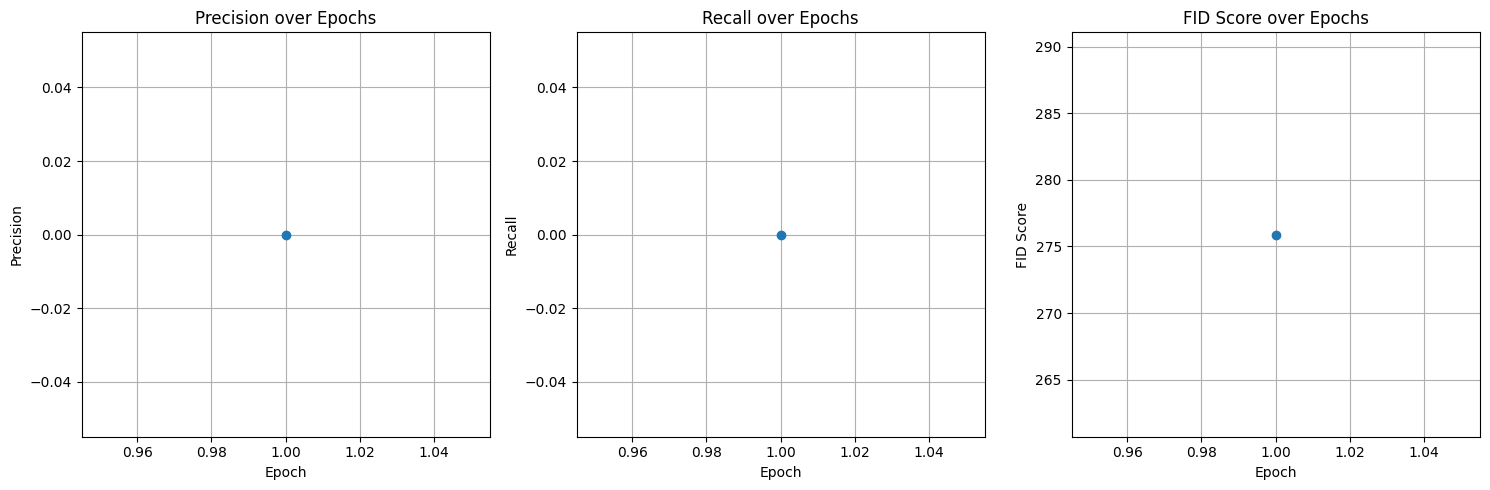

D-real: tensor(-2.2328, device='cuda:0', grad_fn=<DivBackward0>)
D-fake: tensor(1.7589, device='cuda:0', grad_fn=<DivBackward0>)
G-fake: tensor(0.7396, device='cuda:0', grad_fn=<DivBackward0>)


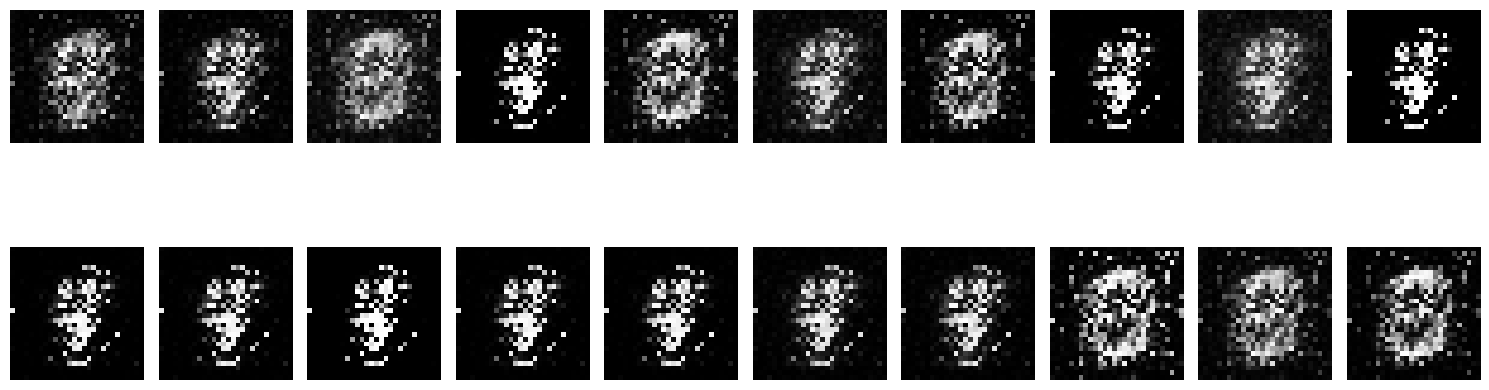

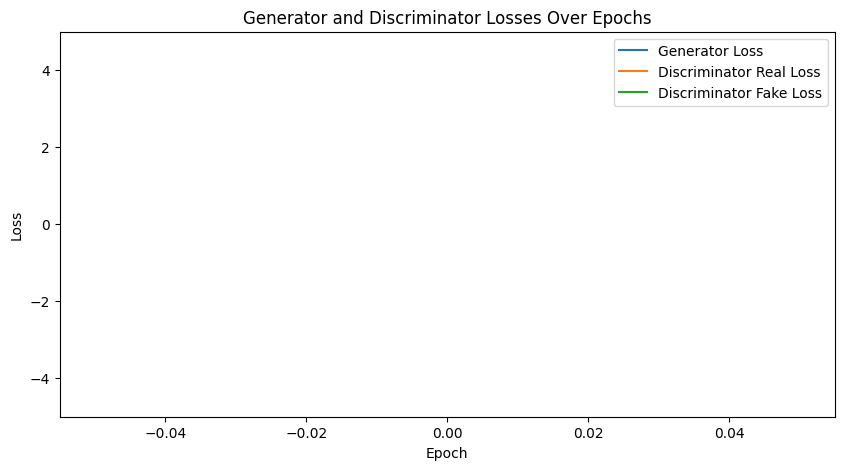

epoch: 2/150


100%|██████████| 469/469 [00:09<00:00, 47.04it/s]


Model loaded.
Start Generating


computing recall...: 100%|██████████| 10000/10000 [00:00<00:00, 17841.68it/s]


Precision: 0.0208
Recall: 0.0
FID: 227.3493716876011


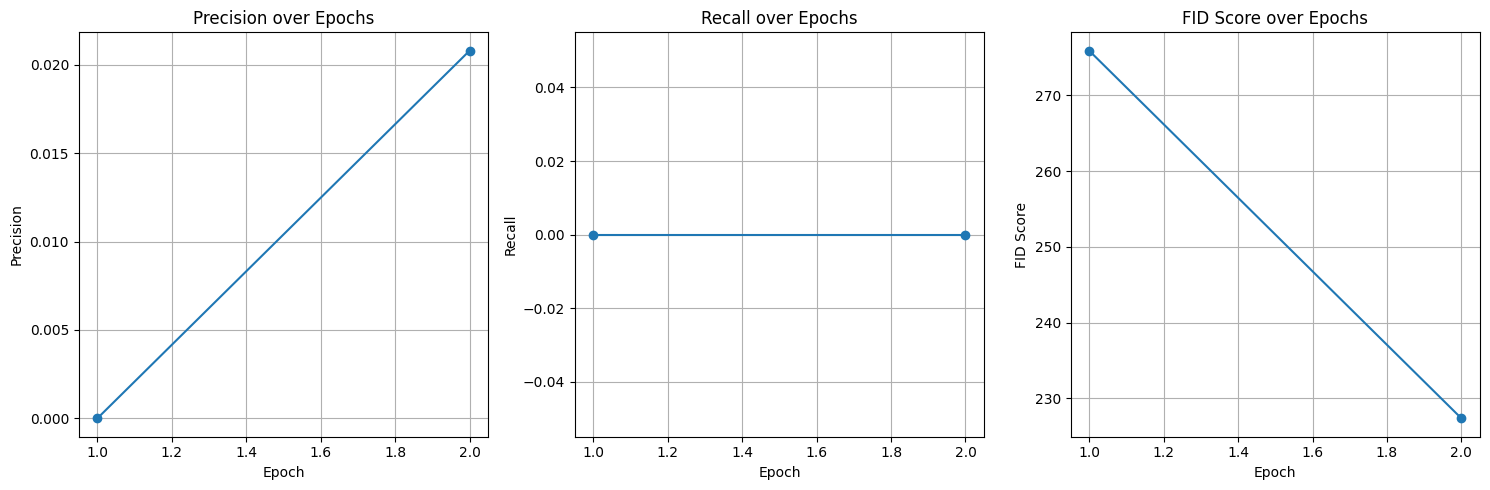

D-real: tensor(-1.0919, device='cuda:0', grad_fn=<DivBackward0>)
D-fake: tensor(-1.4708, device='cuda:0', grad_fn=<DivBackward0>)
G-fake: tensor(1.0979, device='cuda:0', grad_fn=<DivBackward0>)


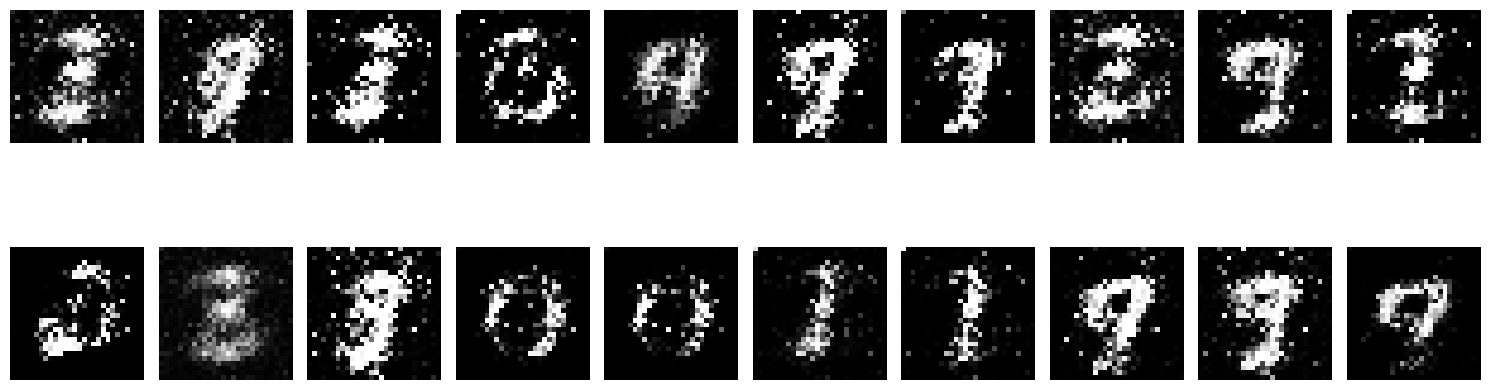

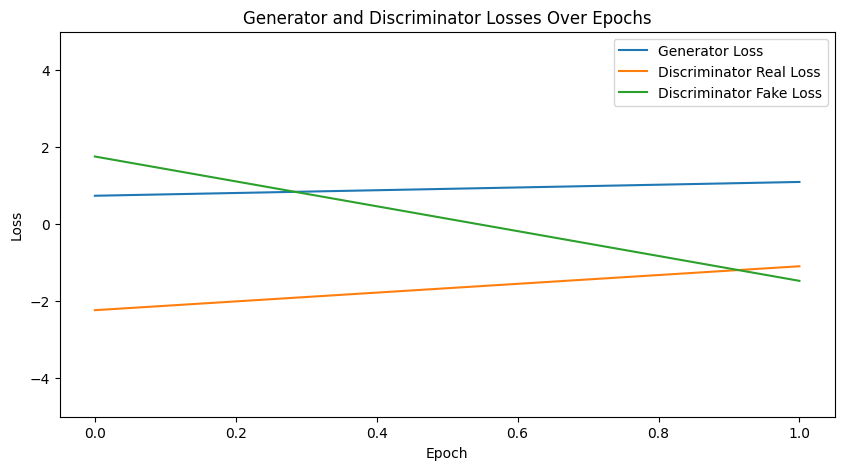

epoch: 3/150


100%|██████████| 469/469 [00:10<00:00, 46.07it/s]


Model loaded.
Start Generating


computing recall...: 100%|██████████| 10000/10000 [00:00<00:00, 17791.74it/s]


Precision: 0.0164
Recall: 0.0
FID: 208.07085424158194


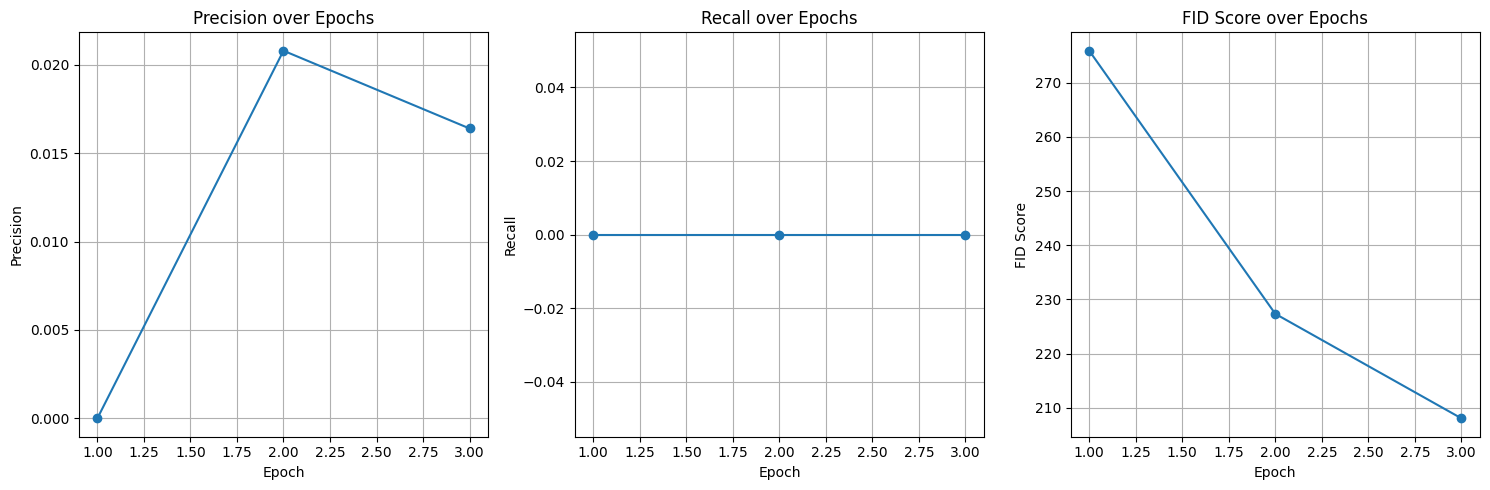

D-real: tensor(-1.3339, device='cuda:0', grad_fn=<DivBackward0>)
D-fake: tensor(-1.8291, device='cuda:0', grad_fn=<DivBackward0>)
G-fake: tensor(1.0000, device='cuda:0', grad_fn=<DivBackward0>)


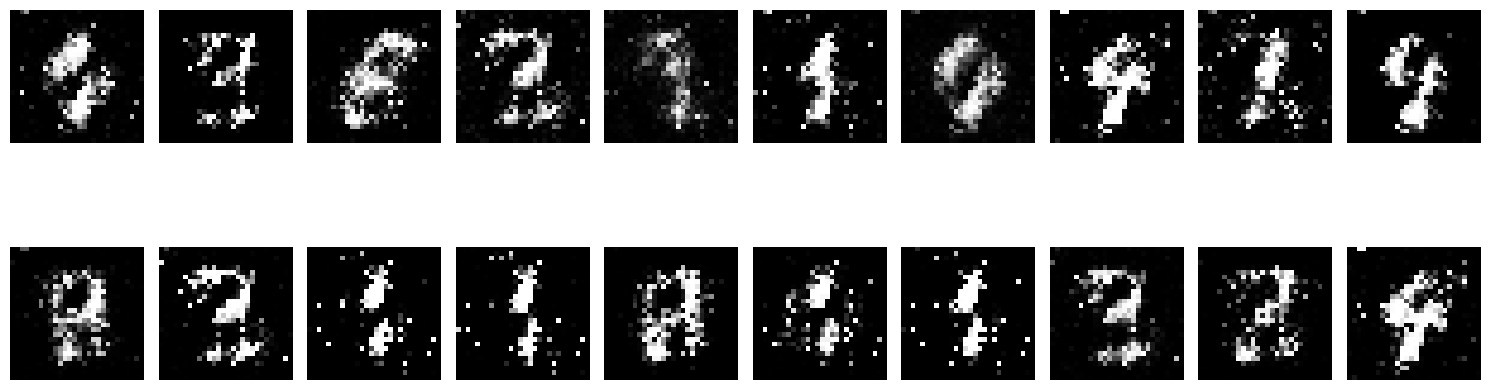

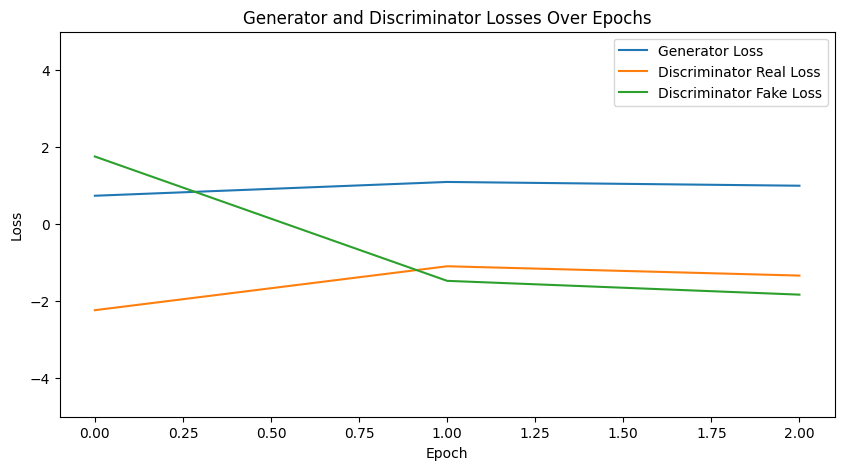

epoch: 4/150


100%|██████████| 469/469 [00:09<00:00, 47.99it/s]


Model loaded.
Start Generating


computing recall...: 100%|██████████| 10000/10000 [00:00<00:00, 18131.29it/s]


Precision: 0.0722
Recall: 0.0002
FID: 183.6951305353084


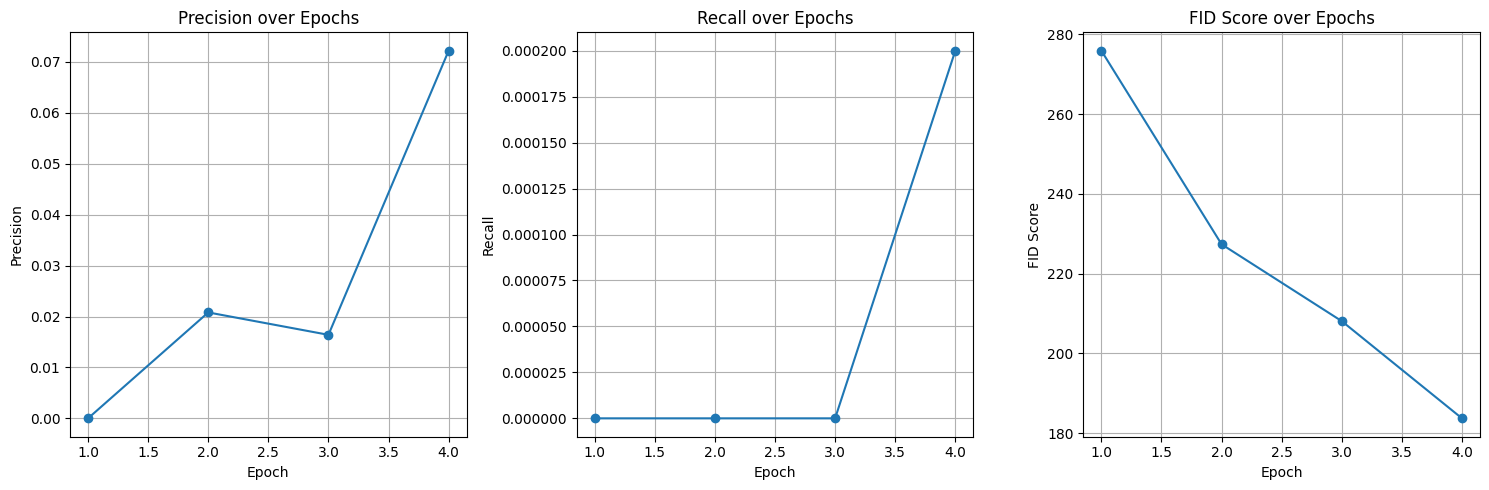

D-real: tensor(-1.3948, device='cuda:0', grad_fn=<DivBackward0>)
D-fake: tensor(-2.0710, device='cuda:0', grad_fn=<DivBackward0>)
G-fake: tensor(0.9842, device='cuda:0', grad_fn=<DivBackward0>)


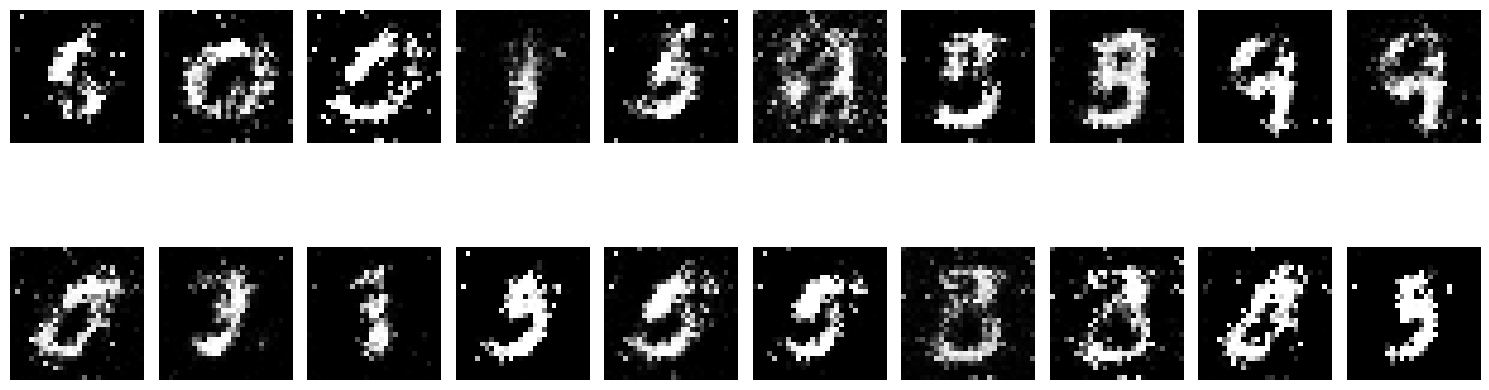

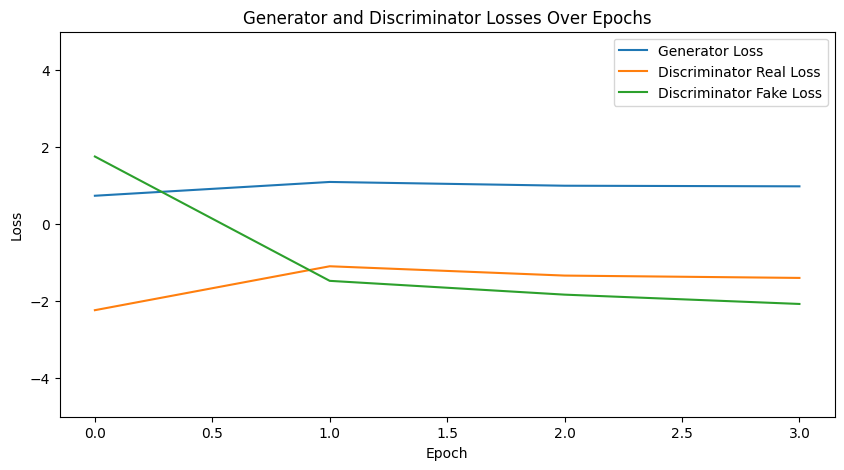

epoch: 5/150


100%|██████████| 469/469 [00:09<00:00, 47.66it/s]


Model loaded.
Start Generating


computing recall...: 100%|██████████| 10000/10000 [00:00<00:00, 17880.56it/s]


Precision: 0.1022
Recall: 0.0009


KeyboardInterrupt: 

In [37]:
G_losses = []
D_real_losses = []
D_fake_losses = [] 
precision_scores = []
recall_scores = []
fid_scores = []

# main training loop
for n in range(params["num_epochs"]):
    loader = iter(train_loader)

    print("epoch: {0}/{1}".format(n + 1, params["num_epochs"]))
    G_loss_epoch = 0
    D_real_loss_epoch = 0
    D_fake_loss_epoch = 0

    for i in trange(steps_per_epoch):
        x, class_ids = next(loader)
        x = x.to(device)
        x = x.view(x.size(0), -1)

        loss_real, loss_fake = update_discriminator(x, discriminator, generator, optimizer_D, params)
        G_loss = update_generator(discriminator, generator, optimizer_G, params, device)

        D_real_loss_epoch += loss_real
        D_fake_loss_epoch += loss_fake
        G_loss_epoch += G_loss

    if (n >= 20) and (n % 20) == 0:
        precision, recall, fid_score = eval_model(generator)
        precision_scores.append(precision)
        recall_scores.append(recall)
        fid_scores.append(fid_score)
        plot_precision_recall_fid(precision_scores, recall_scores, fid_scores)

    # Store the average loss per epoch
    print("D-real:", D_real_loss_epoch / len(train_loader))
    print("D-fake:", D_fake_loss_epoch / len(train_loader))
    print("G-fake:", G_loss_epoch / len(train_loader))
    
    D_real_losses.append(D_real_loss_epoch / len(train_loader))
    D_fake_losses.append(D_fake_loss_epoch / len(train_loader))
    
    G_losses.append(G_loss_epoch / len(train_loader))
    

    plot_generated_images(generator, n+1)
    
    torch.save(generator.state_dict(), ckpt_dir + "g." + str(n) + ".tmp")
    torch.save(discriminator.state_dict(), ckpt_dir + "d." + str(n) + ".tmp")


    # eval
    with torch.no_grad():
        latent = torch.randn(num_samples_per_class * num_class, params["dim_latent"]).cuda()
        imgs_fake = generator(latent).cpu().data.numpy()
        imgs_fake = imgs_fake.reshape(-1, 1, 28, 28)
        save_images(imgs_fake, n, dirname=experiment_name)

    plot_losses(G_losses, D_real_losses, D_fake_losses)

torch.save(generator.state_dict(), ckpt_dir + "generator.pt")
torch.save(discriminator.state_dict(), ckpt_dir + "discriminator.pt")